In [17]:
import sys
import os
sys.path.append('..')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import glob

import utilities.functions as functions
from utilities.functions import (
    segmentacao_3_otimizada,
    retidos11,
    calcula_viabilidade_wide,
)

In [18]:
!pwd

/Users/maceli/ifood_case/code/notebook


In [19]:
!ls -la dados/gold/df_decil.parquet

-rw-r--r--@ 1 maceli  staff  42112041 Nov 30 11:46 dados/gold/df_decil.parquet


In [44]:
df = pd.read_parquet("dados/gold/df_decil.parquet")
df.head(10)


,customer_id,is_target,decil_mes_2_1,decil_mes_2_12,num_pedidos_hist_1,num_pedidos_hist_12,num_pedidos_mes_1,num_pedidos_mes_12,ticket_medio_1,ticket_medio_12,total_amount_mes_1,total_amount_mes_12
0,000009e29b12d8c5b9c9579e21384320c2df3bd935f19e...,control,decil 9,decil 7,10,10,8,2,34.125000,50.000000,273.00,100.00
1,000021924bf8192f64a7cc17ce7c0bc511cba907308f80...,target,decil 9,decil 8,5,5,3,2,57.966667,59.950000,173.90,119.90
2,000022ced2f3aa411b66ac41167b272ae528c4acdffeeb...,target,decil 6,decil 6,4,4,2,2,34.325000,34.325000,68.65,68.65
3,000032b594523c3f8868edee4f1577b157e115cd01ab31...,control,decil 7,decil 7,2,2,1,1,88.800000,88.800000,88.80,88.80
4,0000bb10fb47a1d6b2d73754ef383950ef536c77d07212...,control,decil 9,decil 9,4,4,2,2,94.095000,94.095000,188.19,188.19
5,0000c21984ae00cefb5d4931bfa49483dde546413c9b40...,control,decil 9,decil 9,34,34,23,11,43.972174,48.050909,1011.36,528.56
6,00010814ab1e602ccbc9ffe3b64f44973491b2fd6d8ab7...,control,decil 8,decil 8,4,4,2,2,57.000000,57.000000,114.00,114.00
7,00010e03ea7d7c392a9b6cabcbed034e64fb54214e90bf...,target,decil 8,decil 6,11,11,7,4,19.300000,16.725000,135.10,66.90
8,000116a7bc0a1da0c86ba2dddc02fcc70d35f8b900d693...,target,decil 9,decil 4,9,9,7,2,26.714286,21.450000,187.00,42.90
9,0001226e5175177581c0e520732ba58a61dfa96d57be0c...,target,decil 7,decil 7,4,4,2,2,43.250000,43.250000,86.50,86.50


In [45]:
df['decil_1_num'] = df['decil_mes_2_1'].str.extract(r'(\d+)').astype(int)
df['decil_12_num'] = df['decil_mes_2_12'].str.extract(r'(\d+)').astype(int)
df['delta_decil'] = df['decil_1_num']-df['decil_12_num'] 

In [73]:
df.columns

Index(['customer_id', 'is_target', 'decil_mes_2_1', 'decil_mes_2_12',
       'num_pedidos_hist_1', 'num_pedidos_hist_12', 'num_pedidos_mes_1',
       'num_pedidos_mes_12', 'ticket_medio_1', 'ticket_medio_12',
       'total_amount_mes_1', 'total_amount_mes_12', 'decil_1_num',
       'decil_12_num', 'delta_decil', 'segmento_gasto', 'crescimento_amount',
       'crescimento_pedidos', 'cluster_kmeans'],
      dtype='object')

In [48]:
# Clusters baseados em padrão de consumo
conditions_comportamento = [
    (df['total_amount_mes_1'] > df['total_amount_mes_12']),  # Aumentou gasto
    (df['total_amount_mes_1'] < df['total_amount_mes_12']),  # Reduziu gasto  
    (df['total_amount_mes_1'] == df['total_amount_mes_12'])  # Manteve
]
choices_comportamento = ["Crescimento", "Retração", "Estável"]
df['segmento_gasto'] = np.select(conditions_comportamento, choices_comportamento)

In [49]:
import numpy as np

df['crescimento_amount'] = np.where(
    df['total_amount_mes_12'] == 0,
    0,
    (df['total_amount_mes_1'] - df['total_amount_mes_12']) / df['total_amount_mes_12']
)

df['crescimento_pedidos'] = (df['num_pedidos_mes_1'] - df['num_pedidos_mes_12']) / df['num_pedidos_mes_12']

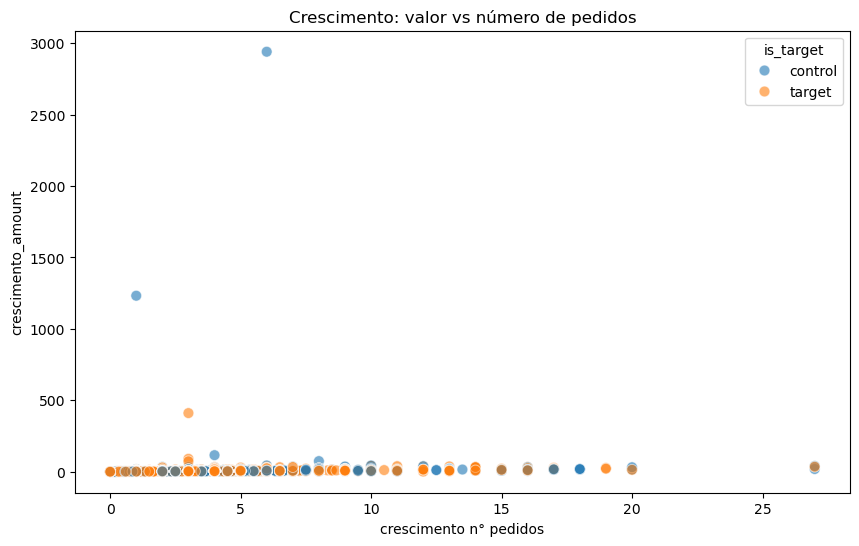

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, y='crescimento_amount', x='crescimento_pedidos', 
                hue='is_target', alpha=0.6, s=60)
plt.title('Crescimento: valor vs número de pedidos')
plt.xlabel('crescimento n° pedidos')

plt.show()

In [59]:
p99 = df['crescimento_amount'].quantile(0.99)

acima_p99 = df[
    df['crescimento_amount'] > p99
]
acima_p99['customer_id'].nunique()

5544

In [ ]:
acima_p99['crescimento_pedidos'].describe()
acima_p99['crescimento_amount'].mean()

count    5544.000000
mean        5.030310
std         2.543902
min         0.500000
25%         3.000000
50%         5.000000
75%         6.000000
max        27.000000
Name: crescimento_pedidos, dtype: float64

In [64]:
df['crescimento_pedidos'].mean()
df['crescimento_amount'].mean()

0.756754604393993

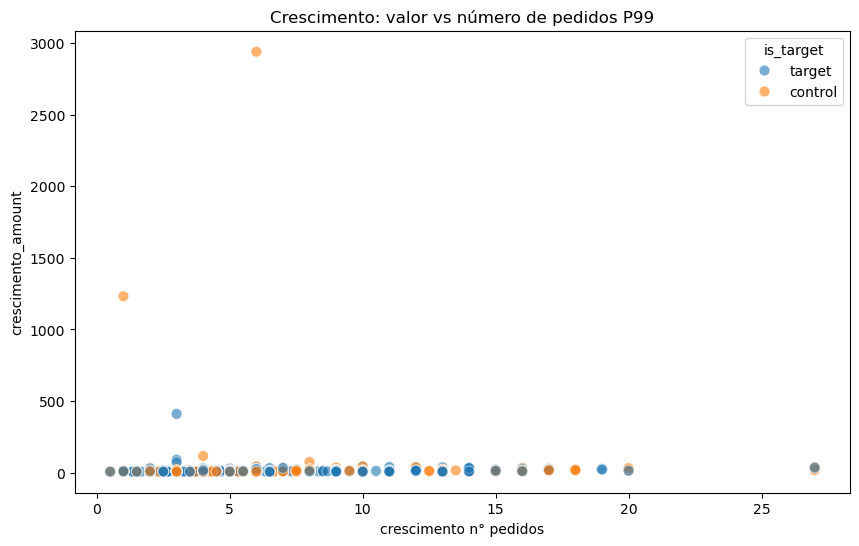

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=acima_p99, y='crescimento_amount', x='crescimento_pedidos', 
                hue='is_target', alpha=0.6, s=60)
plt.title('Crescimento: valor vs número de pedidos P99')
plt.xlabel('crescimento n° pedidos')

plt.show()

In [28]:
# Estatísticas básicas
amount_stats = df['crescimento_amount'].describe().to_dict()
print("Distribuição do crescimento:")
print(amount_stats)

# Estatísticas básicas
pedidos_stats = df['crescimento_pedidos'].describe().to_dict()


Distribuição do crescimento:
{'count': 554376.0, 'mean': 0.756754604393993, 'std': 4.53997502408984, 'min': -1.779693765210019e-16, '25%': 0.0, '50%': 0.0, '75%': 1.007937056492489, 'max': 2940.0}


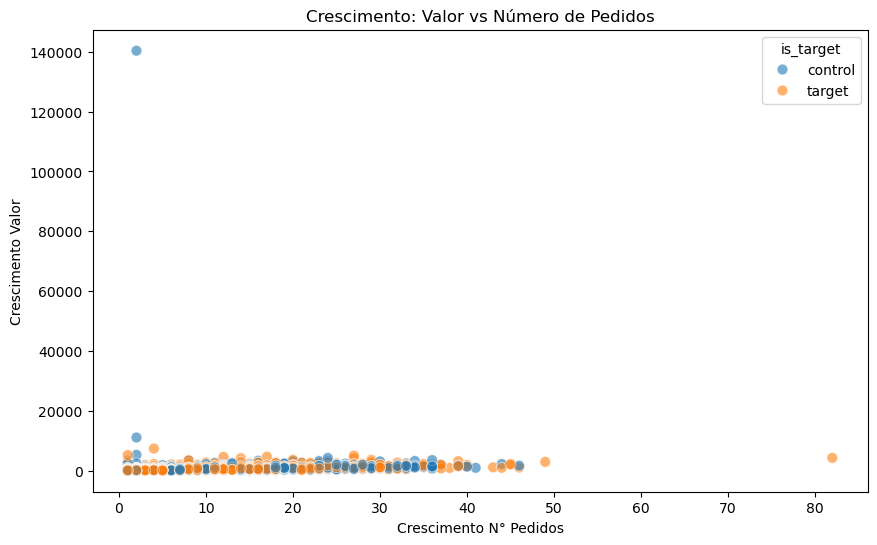

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='num_pedidos_mes_12', y='total_amount_mes_12', 
                hue='is_target', alpha=0.6, s=60)

plt.title('Crescimento: Valor vs Número de Pedidos')
plt.xlabel('Crescimento N° Pedidos')
plt.ylabel('Crescimento Valor')
plt.show()

In [90]:

crescimento_max = df['crescimento_amount'].quantile(0.99) 
df['crescimento_max'] = df['crescimento_amount'].clip(upper=crescimento_max)


features = ['total_amount_mes_1', 'num_pedidos_mes_1']
X = df[features]

from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

df['cluster'] = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(X_scaled)
df.shape

(554376, 22)

In [91]:
resumo = df.groupby('cluster').agg({
    'total_amount_mes_1': 'mean',
    'num_pedidos_mes_1': 'mean',
    'crescimento_max': 'mean',
    'customer_id': 'count'
}).round(2)

print("Perfil dos clusters:")
print(resumo)

Perfil dos clusters:
         total_amount_mes_1  num_pedidos_mes_1  crescimento_max  customer_id
cluster                                                                     
0                    118.41               2.60             0.64       496762
1                    690.53              13.32             1.39        57613
2                 140338.90               2.00             0.00            1


In [96]:
df00=df[(df['num_pedidos_mes_1']==1)& (df['num_pedidos_mes_12']==1)]
df11=df[df['num_pedidos_mes_1']<=10]
df12=df[df['num_pedidos_mes_1']>10]

In [97]:
df00['total_amount_mes_1'].describe()

count    195166.000000
mean         47.561830
std          39.215019
min           0.000000
25%          27.700000
50%          39.900000
75%          56.587500
max        5226.000000
Name: total_amount_mes_1, dtype: float64

In [ ]:

df_1,clientes_retidos_1=retidos11(df11, mes0=12, mes1=1,pedidos=1)
print(clientes_retidos_1)


           retidos    base  taxa_retencao
is_target                                
control     130092  227687       0.571363
target      194723  292294       0.666189
           retidos   base  taxa_retencao
is_target                               
control      13770  13770            1.0
target       20625  20625            1.0


In [ ]:
resultados, agg = calcula_viabilidade_wide(df_1,
                                           mes_campanha=12,
                                           mes_seguinte=1,
                                           coupon_value=10.0,
                                           margin_rate=0.12)

print(resultados)
print(agg)

{'pedidos_por_cliente_camp_control': 2.6766528925619837, 'pedidos_por_cliente_camp_target': 2.8329297820823243, 'pedidos_por_cliente_seg_control': 3.3791322314049586, 'pedidos_por_cliente_seg_target': 3.6472962066182406, 'inc_pedidos_camp': 193.62706611570198, 'inc_pedidos_seg': 332.25516528925647, 'inc_pedidos_total': 525.8822314049585, 'inc_gmv_camp': -2773.9610537189888, 'inc_gmv_seg': 1822.5839152892345, 'inc_gmv_total': -951.3771384297543, 'margem_incremental': -114.16525661157051, 'base_target_camp': 1239, 'custo_campanha': 12390.0, 'lucro_incremental': -12504.16525661157, 'roi': -1.0092143064254697, 'coupon_value': 10.0, 'margin_rate': 0.12, 'mes_campanha': 12, 'mes_seguinte': 1}
           pedidos_campanha  gmv_campanha  pedidos_seguinte  gmv_seguinte  \
is_target                                                                   
control                2591     127769.86              3271     159040.35   
target                 3510     160766.18              4519     205387.66

In [ ]:
resultados, agg = calcula_viabilidade_wide(df_2,
                                           mes_campanha=12,
                                           mes_seguinte=1,
                                           coupon_value=10.0,
                                           margin_rate=0.12)

print(resultados)
print(agg)

{'pedidos_por_cliente_camp_control': 1.3410852713178294, 'pedidos_por_cliente_camp_target': 1.5561497326203209, 'pedidos_por_cliente_seg_control': 5.51937984496124, 'pedidos_por_cliente_seg_target': 6.122994652406417, 'inc_pedidos_camp': 40.217054263565906, 'inc_pedidos_seg': 112.87596899224806, 'inc_pedidos_total': 153.09302325581396, 'inc_gmv_camp': 1089.8780620155035, 'inc_gmv_seg': 3045.1320930232573, 'inc_gmv_total': 4135.010155038761, 'margem_incremental': 496.2012186046513, 'base_target_camp': 187, 'custo_campanha': 1870.0, 'lucro_incremental': -1373.7987813953487, 'roi': -0.734651754756871, 'coupon_value': 10.0, 'margin_rate': 0.12, 'mes_campanha': 12, 'mes_seguinte': 1}
           pedidos_campanha  gmv_campanha  pedidos_seguinte  gmv_seguinte  \
is_target                                                                   
control                 173       7456.36               712      35751.30   
target                  291      11898.71              1145      54870.66   

   

In [ ]:
resultados, agg = calcula_viabilidade_wide(df_3,
                                           mes_campanha=12,
                                           mes_seguinte=1,
                                           coupon_value=10.0,
                                           margin_rate=0.12)

print(resultados)
print(agg)

{'pedidos_por_cliente_camp_control': 1.0833333333333333, 'pedidos_por_cliente_camp_target': 1.1153846153846154, 'pedidos_por_cliente_seg_control': 7.666666666666667, 'pedidos_por_cliente_seg_target': 7.384615384615385, 'inc_pedidos_camp': 0.8333333333333361, 'inc_pedidos_seg': -7.33333333333333, 'inc_pedidos_total': -6.499999999999995, 'inc_gmv_camp': -39.41500000000002, 'inc_gmv_seg': -675.318333333335, 'inc_gmv_total': -714.7333333333349, 'margem_incremental': -85.76800000000019, 'base_target_camp': 26, 'custo_campanha': 260.0, 'lucro_incremental': -345.7680000000002, 'roi': -1.3298769230769238, 'coupon_value': 10.0, 'margin_rate': 0.12, 'mes_campanha': 12, 'mes_seguinte': 1}
           pedidos_campanha  gmv_campanha  pedidos_seguinte  gmv_seguinte  \
is_target                                                                   
control                  13        426.99                92       4696.25   
target                   29        885.73               192       9499.89   

    